# Wave propagation in Time Domain

In this section we discuss how to solve the PDE for 2D sonic wave equation in time domain using `esys.escript`. It is assumed that you have worked through the [introduction section on `esys.escript`](escriptBasics.ipynb). 
First we will provide the basic theory.


## Sonic Wave Equation in Time domain

The sonic wave equation in time domain can be written as a system of first order differential equations:
\begin{equation}\label{eqWAVEF1}
\dot{\mathbf{V}} = - \nabla p 
\end{equation}
\begin{equation}\label{eqWAVEF2}
\frac{1}{c^2} \dot{p} + \nabla^t \mathbf{V} = \delta_{\mathbf{x}_s} \cdot w(t)
\end{equation}
where $p$ is the pressure (or volume change) and 
$\mathbf{V}$ it gradient. Source at location $\mathbf{x}_s$. $c$ is the wave propagation speed.
The dot refers time derivative. $\mathbf{x}_s$ is the location of the source,  
$\delta_{\mathbf{x}_s}$ is Dirac $\delta$-function and $w(t)$ the source wavelet as function of time $t$.
In more details these equations are given as  
\begin{equation}\label{eqWAVEF3}
\dot{\mathbf{V}} = -\begin{bmatrix}
\frac{\partial p}{\partial x_0 }\\
 \frac{\partial p}{\partial x_1 }
\end{bmatrix}
\end{equation}
\begin{equation}\label{eqWAVEF4}
\frac{1}{c^2} \dot{p} + \frac{\partial V_0}{\partial x_0 }+
 \frac{\partial V_1}{\partial x_1 } = \delta_{\mathbf{x}_s}  \cdot w(t)
\end{equation}
For the wavelet we use the [Ricker wavelet](http://subsurfwiki.org/wiki/Ricker_wavelet)

In [1]:
f = 15       # peak frequency of the Ricker wavelet
dt=0.001     # time resolution
tend=0.75    # end of wavelet
%matplotlib inline

We use the implementation in `esys.escript` which is a bit more suitable for us them the [scipy version](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.ricker.html):

In [2]:
from esys.escript import *
from esys.downunder import Ricker
wavelet=Ricker(f)

For plotting we evaluate the Ricker over the interval 0 to `tend`:

In [3]:
import numpy as np
times=np.arange(0,tend, dt)
signal=wavelet.getValue(times)

Text(0.5,1,'Ricker peak frequency =15 Hz')

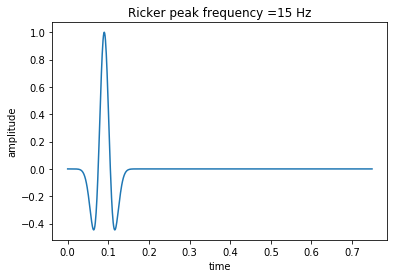

In [4]:

import matplotlib.pyplot as plt

plt.figure()# figsize=(7,7))
plt.plot(times, signal)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title(f'Ricker peak frequency ={f} Hz')

We also want to take a look at the power spectrum. We get the Fourier coefficients and frequencies using `np.fft`.
Notice that we are using the real value fast fourier transformation (FFT) as the values of `signal` are real.
As a consequence only the spectrum for positive frequencies needs to be inspected: 

In [5]:
fourier_full = np.fft.rfft(signal)
freq_all = np.fft.rfftfreq(signal.size, d=dt)

And we plot the power spectrum over frequency:

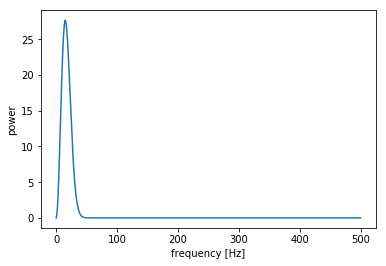

In [6]:
plt.figure()# figsize=(7,7))
plt.plot(freq_all, abs(fourier_full))
plt.xlabel('frequency [Hz]')
plt.ylabel('power')
plt.show()

To assess the requirement is terms of grid sizes for solving the wave equation we need to have an idea of the 
largest frequency making contributions to the signal of the wavelet. To do this we first
need to collect a list of all frequencies for which the spectrum lays above a threshold. Here we
use $0.001$ times the maximum spectrum value to get an index of all frequencies that have 
significant contribution to the signal:

In [7]:
freq_index=np.where( abs(fourier_full) > max(abs(fourier_full))*0.001 )[0]

Then we grab the relevant frequencies from the array of frequencies and get the max:

In [8]:
fmax=max(freq_all[freq_index])
print(f"maximum freqency = {fmax} Hz")

maximum freqency = 46.666666666666664 Hz


## Domain set up

We consider a single reflector set up. The reflector is located at a depth of $500m$
where the top layer has propagation speed of $c_{top}=1500m/s$ 
and the bottom layer has propagation speed of $c_{top}=3000m/s$.
Use a frequency of $f=5 Hz$. The domain has depth of $1km$ and width $3km$ 
with $300 \times 100$ grid.
The source is located at the surface at an offset of $1500m$ from the boundary.

 <img src="SonicImage1.png" alt="Sonic domain" width="800"> 

This time we use a `sys.speckley` domain which is more suitable for wave problems. It actual uses higher 
order polynomial approximations:

In [9]:
nx=100  # elements in horizontal direction
ny=60   # elements in vertical direction
dx=15   # element size
order=6 # element order

In [10]:
Width=nx*dx
Depth=ny*dx
print(f"Domain dimension is {Width} x {Depth}")

Domain dimension is 1500 x 900


Again we use a single source at the center of the top edge of the domain:

In [11]:
from esys.speckley import Rectangle
sources=[(Width/2, Depth) ]
sourcetags=["source66" ]
domain = Rectangle(order, n0=nx, n1=ny, l0=Width, l1=Depth, diracPoints=sources, diracTags=sourcetags) 

Velocity configuration is

In [12]:
c_top=1800      # m/s
c_bottom=3000      # m/s
d0=Depth-200.    # m top layer is 200m thick

Set up of the velocity $c$:

In [13]:
X=ReducedFunction(domain).getX()
m=wherePositive(X[1]-d0)
c=c_top*m+c_bottom*(1-m)
c=interpolate(c, Function(domain))

We solve the wave equation using the Heun scheme which is 2-nd order Runge-Kutta method with time step size: Starting from $U^{(0)}$:
\begin{equation}\label{eq:H1}
\hat{U}^{(n+1)} =  U^{(n)} + h \cdot F(U^{(n)}, t^{(n)}) 
\end{equation}
\begin{equation}\label{eq:H2}
\hat{U}^{(n+1)} = U^{(n)} + \frac{h}{2} (F(U^{(n)}, t^{(n)})+F(\hat{U}^{(n+1)}, t^{(n+1)}) )
\end{equation}
In our case:
\begin{equation}\label{eqWAVEF8}
U=\begin{bmatrix}
\mathbf{V}\\
 p
\end{bmatrix}
\end{equation}
and 
\begin{equation}\label{eqWAVEF9}
F=\begin{bmatrix}
-\nabla p\\
 dp
\end{bmatrix}
\end{equation}
with 
\begin{equation}\label{eqWAVEF10}
\frac{1}{c^2} dp = - \nabla^t \mathbf{V} + \delta_{\mathbf{x}_s} \cdot w(t)
\end{equation}
for which we use the `LinearSinglePDE` with $D=\frac{1}{c^2}$, $X=-\mathbf{V}$ and
$y_{dirac}=\delta_{\mathbf{x}_s} \cdot w(t)$

Define the PDE:

In [14]:
from esys.escript.linearPDEs import LinearSinglePDE, SolverOptions
pde = LinearSinglePDE(domain)
pde.getSolverOptions().setSolverMethod(SolverOptions.LUMPING)

Setting $D$ is the PDE:

In [15]:
pde.setValue(D=1./(c**2) )

An define the Dirac $\delta$ function for the source `source66` which we will later multiply with the wavelet value $(w(t)$ to define $y_{dirac}$: 

In [16]:
input_loc=Scalar(0., DiracDeltaFunctions(domain))
input_loc.setTaggedValue("source66", 1.)

The wave length $\lambda$ needs to smaller then the node spacing in order to be able to resolve
the wave and its gradient accurately (note $2\pi f \lambda=c$):

In [17]:
dx_max=inf(c/(2*np.pi*fmax))
dx_used=dx/order
print(f"maximum grid step size = {dx_max}. found = {dx_used}")

maximum grid step size = 6.13883351925882. found = 2.5


## Time integrations

Also should the changes between to time steps not be two dramatic in the sense that the wave from should not
travel more than then a node distance within a time step. This leads to the condition $h<h_max$:

In [18]:
h_max=inf(dx/c/order)
print(f"maximum time step size = {h_max}.")

maximum time step size = 0.0008333333333333334.


** Note **: if the time step is two large then solution can become unstable. The exact maximum size 
    depends on additional factors such as the time integration scheme and the spatial discretization scheme.
    In some an exact correction factor is known but here we use $h_{max}$ as a guidance to find the appropriate step size.

This is a Heun step:

In [19]:
def stepHeun(t, p, v, n, h):
    for k in range(n):
        
        dv1=grad(p)

        a=wavelet.getValue(t+k*h)
        #print(t+k*h, a)
        pde.setValue(X=-v, y_dirac=input_loc*a)
        dp1=pde.getSolution()
        
        vp=v+dv1*h
        pp=p+dp1*h
            
        dv2=grad(pp)
        a=wavelet.getValue(t+k*h+h)
        pde.setValue(X=-vp, y_dirac=input_loc*a)
        dp2=pde.getSolution()
        
        v=v+(dv1+dv2)*h/2
        p=p+(dp1+dp2)*h/2


    return t+n*h, p, v

We want to track the solution at three locations at the surface:

In [21]:
from esys.escript.pdetools import Locator
loc0=Locator(Solution(domain), x=( Width/2, Depth) )
loc1=Locator(Solution(domain), x=( Width/2*0.9, Depth) )
loc2=Locator(Solution(domain), x=( Width/2*0.5, Depth) )

And also collect over a set of virtual geophones to create a synthetic seismic survey:

In [22]:
loc=Locator(Solution(domain), x=[ ( Width/2+z, Depth) for z in np.linspace(-500, 500, 80) ] )

We write a function to progress the time integration from some time `t` to some 
time `tend` and collect the values at the geophones over time is lists:

In [38]:
Ts=[]
Trace0=[]
Trace1=[]
Trace2=[]
Traces=[]
h=0.00004
n=int(dt/h)
print("n= ",n)

def progress(p, v, t, tend):
    while t < tend:
        t, p, v = stepHeun(t, p, v, n, h)
        Ts.append(t)
        Trace0.append(loc0(p))
        Trace1.append(loc1(p))
        Trace2.append(loc2(p))
        Traces.append(loc(p))
        #print(Ts[-1], Trace0[-1], Trace1[-1], Trace2[-1])
    return t, p, v

n=  25


We set the initial values and progress to $20\%$ of the total end time. This will take some time:

In [39]:
# start time integration
v=Vector(0., Function(domain))
p=Scalar(0., Solution(domain))
t=0    

t, p, v = progress(p, v, t, tend*0.2)

Lets plot the solution at that time:

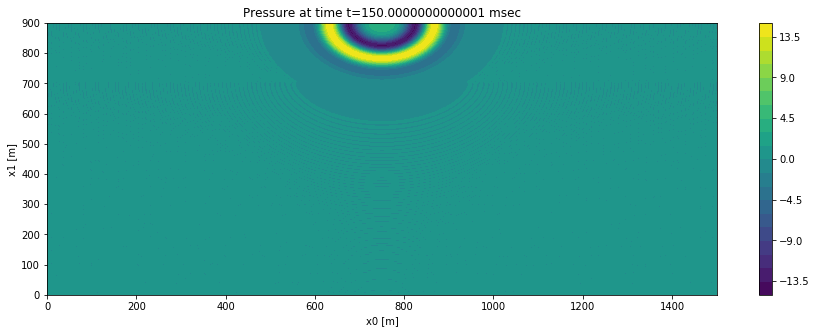

In [40]:
p_np=convertToNumpy(p)
x_np=convertToNumpy(p.getFunctionSpace().getX())
plt.figure(figsize=(15,5))
plt.tricontourf(x_np[0], x_np[1], p_np[0], 20)
plt.xlabel('x0 [m]')
plt.ylabel('x1 [m]')
plt.title(f"Pressure at time t={t*1000.} msec")
plt.colorbar()
plt.show()

And now progress to $40\%$ end time:

In [42]:
t, p, v = progress(p, v, t, tend*0.4)

Lets plot the solution at that time:

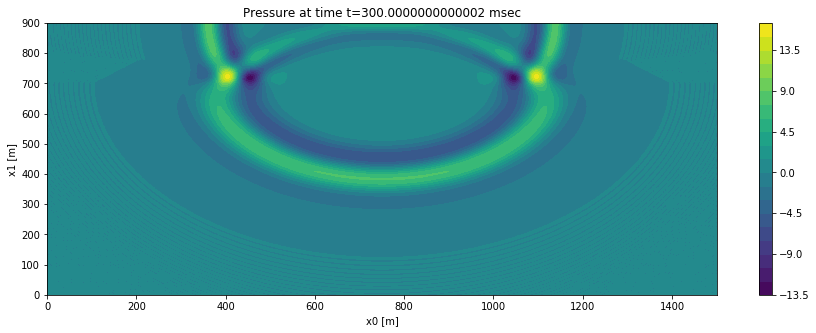

In [43]:
p_np=convertToNumpy(p)
x_np=convertToNumpy(p.getFunctionSpace().getX())
plt.figure(figsize=(15,5))
plt.tricontourf(x_np[0], x_np[1], p_np[0], 20)
plt.xlabel('x0 [m]')
plt.ylabel('x1 [m]')
plt.title(f"Pressure at time t={t*1000.} msec")
plt.colorbar()
plt.show()

And now progress to 60%
end time:

In [45]:
t, p, v = progress(p, v, t, tend*0.6)

Lets plot the solution at that time:

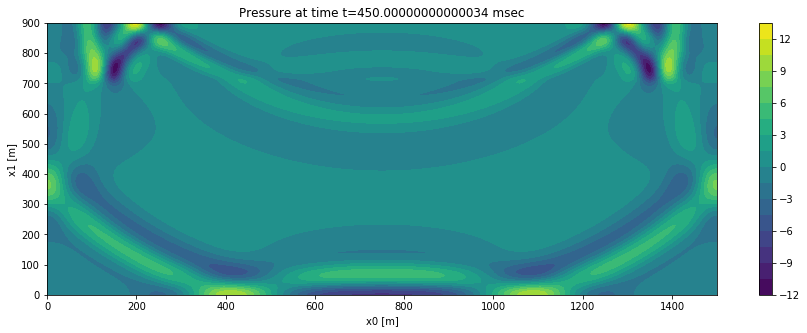

In [46]:
p_np=convertToNumpy(p)
x_np=convertToNumpy(p.getFunctionSpace().getX())
plt.figure(figsize=(15,5))
plt.tricontourf(x_np[0], x_np[1], p_np[0], 20)
plt.xlabel('x0 [m]')
plt.ylabel('x1 [m]')
plt.title(f"Pressure at time t={t*1000.} msec")
plt.colorbar()
plt.show()

And now progress to 80% end time:

In [50]:
t, p, v = progress(p, v, t, tend*0.8)

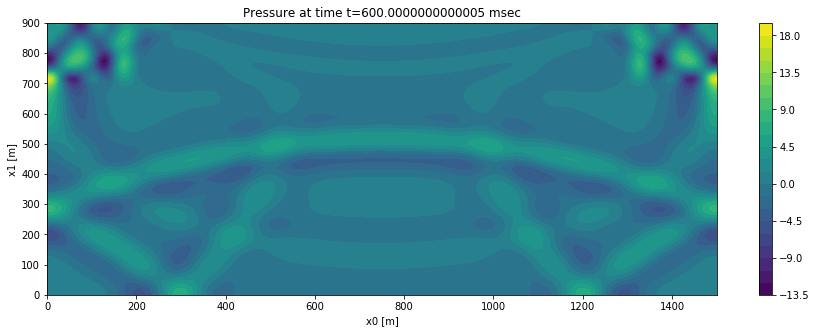

In [51]:
p_np=convertToNumpy(p)
x_np=convertToNumpy(p.getFunctionSpace().getX())
plt.figure(figsize=(15,5))
plt.tricontourf(x_np[0], x_np[1], p_np[0], 20)
plt.xlabel('x0 [m]')
plt.ylabel('x1 [m]')
plt.title(f"Pressure at time t={t*1000.} msec")
plt.colorbar()
plt.show()

## Seismograms

Plot the traces at the monitoring points:

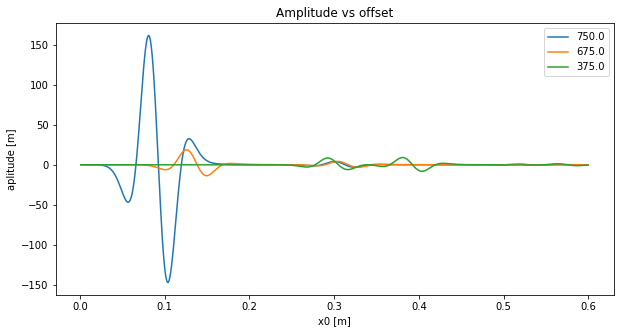

In [52]:
plt.figure(figsize=(10,5))
plt.plot(Ts, Trace0, label="%s"%(loc0.getX()[0]))
plt.plot(Ts, Trace1, label="%s"%(loc1.getX()[0]))
plt.plot(Ts, Trace2, label="%s"%(loc2.getX()[0]))

plt.xlabel('x0 [m]')
plt.ylabel('aplitude [m]')
plt.title("Amplitude vs offset")
plt.legend()

In [53]:
traces=np.array(Traces)

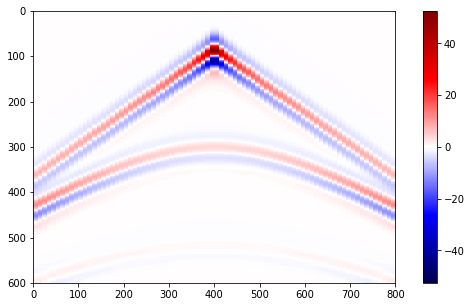

In [57]:
a=abs(traces).max()
plt.figure(figsize=(10,5))
plt.imshow(traces, extent=(0, 80*10, len(Traces),0), cmap='seismic', vmin=-a, vmax=a )
plt.colorbar()